In [1]:
%matplotlib inline

import numpy as np
from numpy import linalg as nla
import scipy as sp
from scipy import linalg as sla
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from time import time
import SHFunctions as shf
import os

    A = shf.MakeStochA(4,6)

In [2]:
    A = shf.MakeSingularA(3, 2, delta = .00010)

    A = np.array([[[0, 1/3, 1/3],
                   [1/3, 0, 1/3],
                   [1/3, 1/3, 0]],
                  [[-2, 1/3, 1/3],
                   [1/3, -2, 1/3],
                   [1/3, 1/3, -2]],
                  [[0, 1/3, 1/3],
                   [1/3, 0, 1/3],
                   [1/3, 1/3, 0]]])

    A = np.array([[[1, 0, 0],
                   [0, 2, 0],
                   [0, 0, 2]],
                  [[-2, 0, 0],
                   [0, -3, 0],
                   [0, 0, -3]],
                  [[1, 0, 0],
                   [0, 1, 0],
                   [0, 0, 1]]])

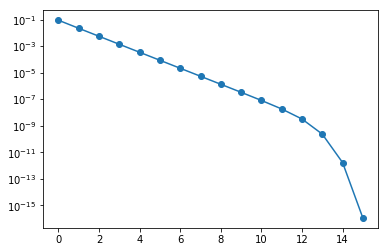

In [3]:
    Ss = shf.NewtonPoly(A)
    ax = plt.subplot(111)
    ax.semilogy(Ss['errs'],'-o')

In [4]:
    di = np.zeros((len(Ss['P_Xs']), Ss['P_Xs'][0].shape[0]))
    di = di.astype(complex)
    i = 0
    for P in Ss['P_Xs']:
        d, X = nla.eig(P)
        di[i, :] = d
        i += 1
    print(di.dtype)

complex128


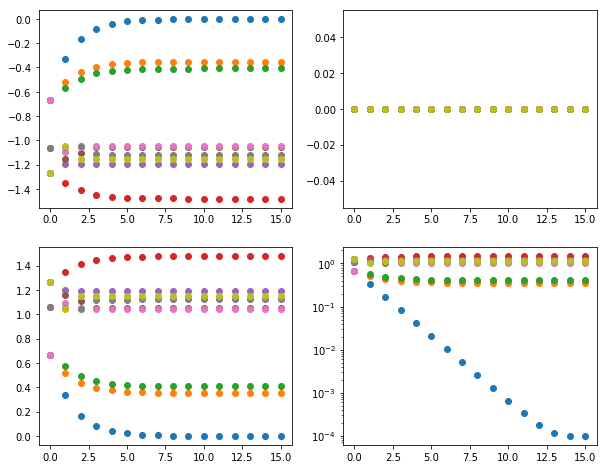

In [5]:
    fig, axes = plt.subplots(2, 2,figsize=(10, 8))
    for i in range(di.shape[1]):
        axes[0,0].plot(np.real(di[:,i]),'o')
        axes[0,1].plot(np.imag(di[:,i]),'o')
        axes[1,0].plot(np.absolute(di[:,i]),'o')
        axes[1,1].semilogy(np.absolute(di[:,i]),'o')
        i += 1

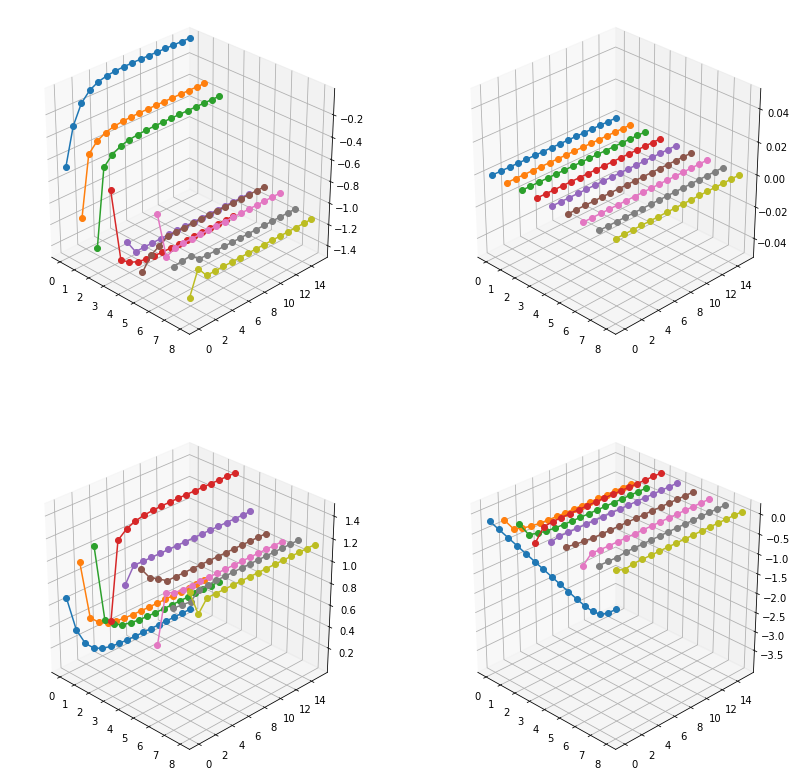

In [6]:
    fig1 = plt.figure(figsize=(14,14))
    ax1 = fig1.add_subplot(221, projection='3d')
    ax2 = fig1.add_subplot(222, projection='3d')
    ax3 = fig1.add_subplot(223, projection='3d')
    ax4 = fig1.add_subplot(224, projection='3d')
    for i in range(di.shape[1]):
        ax1.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.real(di[:,i]),'-o')
        ax2.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.imag(di[:,i]),'-o')
        ax3.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.absolute(di[:,i]),'-o')
        ax4.plot(i*np.ones(di.shape[0]), np.arange(di.shape[0]), np.log10(np.absolute(di[:,i])),'-o')
        i += 1
    ax1.view_init(30, 315)
    ax2.view_init(30, 315)
    ax3.view_init(30, 315)
    ax4.view_init(30, 315)

    di = []
    for P in Ss['P_Xs']:
        d, X = nla.eig(P)
        di.append(d)
    fig, axes = plt.subplots(1,2,figsize=(10, 4))
    i = 0
    for d in di:
        axes[0].plot(i*np.ones(d.shape[0]), np.real(d),'o')
        axes[1].plot(i*np.ones(d.shape[0]), np.imag(d),'o')
        i += 1
    print(len(di))

In [8]:
    Ss['Hs'][-1]

array([[-2.78605047e-09, -7.28478443e-09, -6.07197171e-09],
       [-2.78605048e-09, -7.28478440e-09, -6.07197171e-09],
       [-2.78605048e-09, -7.28478442e-09, -6.07197174e-09]])

    # H 간의 상수배 차이
    for i in range(len(Ss['Hs'])-1):
        j = i + 1
        TT = Ss['Hs'][i] / Ss['Hs'][j]
        print(np.mean(TT))
        print(TT - np.mean(TT))

    # H_{i+1}과 H_{i} 간, 내적을 통한 cos 값
    TT = []
    for i in range(len(Ss['Hs'])-1):
        cosH = np.trace(np.dot(Ss['Hs'][i+1].transpose(),Ss['Hs'][i]))
        cosH /= (nla.norm(Ss['Hs'][i+1], 'fro') * nla.norm(Ss['Hs'][i], 'fro'))
        TT.append(cosH)
    TT

    # 멀리 떨어져있는 H들 사이, 내적을 통한 cos 값
    i, j = 5, -1
    cosH = np.trace(np.dot(Ss['Hs'][j].transpose(),Ss['Hs'][i])) / (nla.norm(Ss['Hs'][j], 'fro') * nla.norm(Ss['Hs'][i], 'fro'))
    print(cosH)

    d, X = nla.eig(Ss['P_Xs'][-1])

    kk = -1
    x1 = np.dot(Ss['P_Xs'][kk],np.reshape(Ss['Hs'][kk],(Ss['Hs'][kk].shape[0]*Ss['Hs'][kk].shape[1],1),order='F'))
    x2 = d[0]*np.reshape(Ss['Hs'][kk],(Ss['Hs'][kk].shape[0]*Ss['Hs'][kk].shape[1],1),order='F')
    print(x1)
    print(x2)
    print(np.absolute(x1 - x2) < 1e-16)

    # S - X_{i}와 X_{i+1} - X_{i}의 Frobenius norm 구하기
    nSmX = []
    for X in Ss['Xs']:
        nSmX.append(nla.norm(Ss['sol'] - X,'fro'))

    nXmX = []
    for i in range(len(Ss['Xs'])-1):
        nXmX.append(nla.norm(Ss['Xs'][i+1] - Ss['Xs'][i],'fro'))

    # 그래프로 S - X_{i}와 X_{i+1} - X_{i} 비교
    dXoverdX = [nXmX[i+1] / nXmX[i] for i in range(len(nXmX)-1)]
    dSoverdS = [nSmX[i+1] / nSmX[i] for i in range(len(nSmX)-1)]
    fig, axes = plt.subplots(2,2,figsize=(10, 8))
    axes[0,0].semilogy(nSmX,'-ob')
    axes[0,1].semilogy(nSmX,'-ob')
    axes[0,1].semilogy(nXmX,'-or')
    axes[1,0].plot(dSoverdS,'-ob')
    axes[1,1].plot(dSoverdS,'-ob')
    axes[1,1].plot(dXoverdX, '-or')